# Generative Gaussian Mixture Example

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import matplotlib.transforms as transforms
from matplotlib.patches import Ellipse

using a simple bidimensional dataset, created using the make_blobs()
provided by scikit-learn.
This function allows creating synthetic datasets to test algorithms that
require data points drawn from a set of normal distributions. The goal of the example is to show the dynamics of a Generative Gaussian Mixture, and
therefore we have voluntarily avoided more complex datasets that cannot be
easily visualized.

In [31]:
from sklearn.datasets import make_blobs
nb_samples = 250
nb_unlabeled = 200
X, Y = make_blobs(n_samples= nb_samples,n_features =2, centers = 2,
                 cluster_std = 1.25, random_state = 100)

unlabeled_idx = np.random.choice(np.arange(0,nb_samples,1),
                                 replace = False,size=nb_unlabeled)
#np.arange (start , end ,step)
Y[unlabeled_idx] = -1


Let's now visualize our dataset and see how we will it looks like

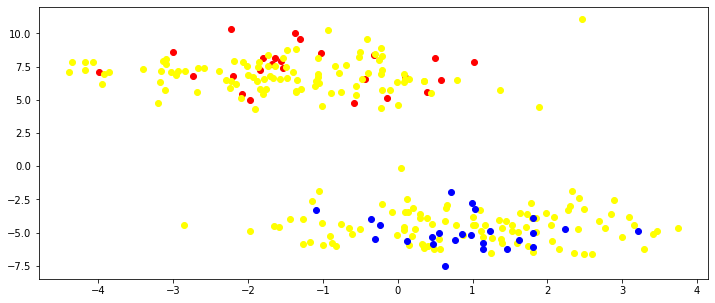

In [32]:


Y_1 = []
Y_0 = []
Y_unsampled = []

for idx in range(len(Y)):
    if Y[idx] == 0 :
        Y_0.append(idx)
    elif Y[idx] == 1:
        Y_1.append(idx)
    else:
        Y_unsampled.append(idx)
X_1 = X[:,1]
X_0 = X[:,0]
class00 = []
class10 = []
class_unsampled0 = []

class01 = []
class11 = []
class_unsampled1 = []

for i in Y_0:
    class00.append(X[i,0])
    class01.append(X[i,1])
    
for i in Y_1:
    class10.append(X[i,0])
    class11.append(X[i,1])
    
for i in Y_unsampled:
    class_unsampled0.append(X[i,0])
    class_unsampled1.append(X[i,1])

#graph creation         
plt.figure(figsize=(12,5))
plt.scatter(class10,class11,color= 'red')
plt.scatter(class_unsampled0,class_unsampled1,color="yellow")
plt.scatter(class00,class01,color="blue")

plt.show()

We've created 200 samples belonging to 2 classes 250 points  have then been randomly selected to become our unlabeled dataset (the coresponding class) 
We can now initialize two Gaussian dist. by defining their mean,Covariance, and weight.
One possibility is to use random values; this choice is the simplest and doesn't require and prior calculation.
the algorithm has been proven to converge in any case.
but the number of steps is a function of the difference between the initial and final states:

## Initializing main parameters

In [33]:
import numpy as np
#initialized two random variables in ml list (mean,covariance)
m1 = np.random.uniform(7.5,10.0,size=2)
c1 = np.random.uniform(5,15,size = (2,2))
c1 = np.dot(c1,c1.T)
q1 = 0.5

m2 = np.random.uniform(7.5,10.0,size=2)
c2 = np.random.uniform(5,15,size = (2,2))
c2 = np.dot(c2,c2.T)
q2 = 0.5


print(c1)

[[289.11601481 244.81366522]
 [244.81366522 241.16537092]]


covariance matrices must be positive semi-definite.

A semi-definite matrix is a matrix where (A) is N by N matrix and the v(eigenvalues) is <> 0 and >0 and the diagonal matrix Transpose x matrix A x diagonal matrix

The variance is a squared quantity, therefore its's nonnegative.A covariance-matrix is is an extension of the concept of variance
that must inherit the same properties.

In particular, when the Gaussian is
aligned with the axis, all non-diagonal terms are null. On the diagonal there are the variances with respect to every component, which are also the eigenvalues. 

In particular, when the Gaussian is
aligned with the axis, all non-diagonal terms are null. On the diagonal there are the variances with respect to every component, which are also the eigenvalues. It's straightforward to understand that all these terms are nonnegative.

Since we don't know the structure of the dataset before training
the model, we cannot easily define a criterion to initialize all the parameters
in the optimal way without complex calculations.

A Simple trade-of is setting the weights as 1/N classes and setting the covariance matrices and means equal to the sample covariance and means.
In this way, all the Gaussians will be overlapped and the algo will deform to match the input dist.

we could pick M1/2 and C1/2 as the covar. matrices and Q1/2 as the weights

In [34]:
m1 = np.array([-2.0,-2.5])
c1 = np.array([[1.0,1.0],[1.0,2.0]])
q1 = 0.5

m2 = np.array([1.0,3.0])
c2 = np.array([[2.0,-1.0],[-1.0,3.5]])
q2 = 0.5

## Computing angles

If we project the Gaussians on the XY plane and truncate them by limiting the range of independent variables, you'll be able to see that they appear as eclipses 
In order to determine their structure and orientation, we need to observe:
The major axis *Vm1/2* is oriented as the eigenvector associated with the largest eigenvalue of the covariance matrix. As the same way the minor axis *Vm1/2* is orineted as the eigenvector with the smallest eigenvalue 

The eccentricity e is equal to the ration between the two eigenvalues when e =1 , the ellipse is a circle because both axes have the same length when e<>1 the ellipse is a proper one, stretched along one of the two axes.

to find the orientation of  (a1/2) of the major axis (v1/2) we get
Vm* e = || Vm || * || e || cos(a1/2) ==> a1/2 
= arcos ((vm1/2*e) / |Vm|| || e ||) 


In [35]:
w1, v1 = np.linalg.eigh(c1)
w2, v2 = np.linalg.eigh(c2)

nv1 = v1 / np.linalg.norm(v1)
nv2 = v2 / np.linalg.norm(v2)

a1 = np.arccos(np.dot(nv1[:,1],[1.0,0.0])/np.linalg.norm(nv1[:,1])
             )*180/np.pi

a2 = np.arccos(np.dot(nv2[:,1],[1.0,0.0])/ np.linalg.norm(nv2[:,1])
              )*180/np.pi
print("<------------------------------->")
print("angle 1:" , a1)
print("angle 2:" , a2)
print("<------------------------------->")

<------------------------------->
angle 1: 58.282525588538995
angle 2: 116.56505117707799
<------------------------------->


We have now
- v1,v2--> eigenverctors  
- nv1,nv2--> the norm of eigenvectors
- a1,a2 --> angles of rotations 
- m1,m2 --> mean of two classes
- c1,c2 --> covariances
- q1,q2 --> as weights

we will now shift to *confidence_elipse* and how to create a function 
which takes parameters and give an oval shaped ellipses

note: this function will be then split in two cases in future case. 

## Ellipses

In [36]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none',angle=45 ,cov = "",mean_x = "",mean_y = "",**kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """

    
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    #if the covariance is not give to craete modified ellipse
    # the ellipse will be created using x and y dataset
    if cov == "":
        cov = np.cov(x,y)
    if mean_x ==  "":
        mean_x = np.mean(x)
    if mean_y == "":
        mean_y = np.mean(y)
    
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)

    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
 
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    
    transf = transforms.Affine2D() \
        .rotate_deg(angle) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)



# for examples only :
# this function  creates a correlated dataset in a give direction
def get_correlated_dataset(n, dependency, mu, scale):
    latent = np.random.randn(n, 2)
    dependent = latent.dot(dependency)
    scaled = dependent * scale
    scaled_with_offset = scaled + mu
    
    # return x and y of the new, correlated dataset
    return scaled_with_offset[:, 0], scaled_with_offset[:, 1]



### example for ellipses in different correlations

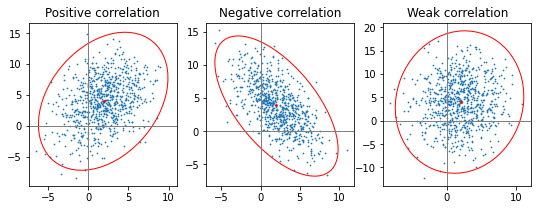

In [37]:
## the sy
PARAMETERS = {
    'Positive correlation': np.array([[0.85, 0.35],
                                      [0.15, -0.65]]),
    'Negative correlation': np.array([[0.9, -0.4],
                                      [0.1, -0.6]]),
    'Weak correlation': np.array([[1, 0],
                                  [0, 1]]),
}

mu = 2, 4
scale = 3, 5

fig, axs = plt.subplots(1, 3, figsize=(9, 3))
for ax, (title, dependency) in zip(axs, PARAMETERS.items()):
    x, y = get_correlated_dataset(800, dependency, mu, scale)
 
    ax.scatter(x, y, s=0.5)

    ax.axvline(c='grey', lw=1)
    ax.axhline(c='grey', lw=1)

    confidence_ellipse(x, y, ax, edgecolor='red',angle = 45)

    ax.scatter(mu[0], mu[1], c='red', s=3)
    ax.set_title(title)

plt.show()

### Example of an ellipse in Different Deviations

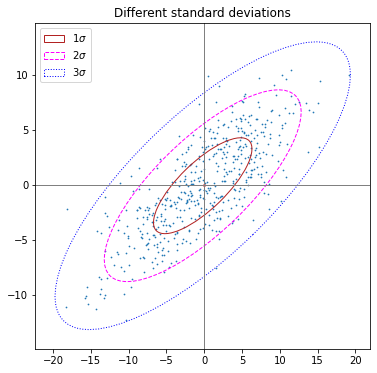

In [38]:
fig, ax_nstd = plt.subplots(figsize=(6, 6))

dependency_nstd = np.array([
    [0.8, 0.75],
    [-0.2, 0.35]
])
mu = 0, 0
scale = 8, 5

ax_nstd.axvline(c='grey', lw=1)
ax_nstd.axhline(c='grey', lw=1)

x, y = get_correlated_dataset(500, dependency_nstd, mu, scale)
ax_nstd.scatter(x, y, s=0.5)

confidence_ellipse(x, y, ax_nstd, n_std=1,
    label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2,
    label=r'$2\sigma$', edgecolor='fuchsia', linestyle='--')
confidence_ellipse(x, y, ax_nstd, n_std=3,
    label=r'$3\sigma$', edgecolor='blue', linestyle=':')

ax_nstd.scatter(mu[0], mu[1], c='red', s=3)
ax_nstd.set_title('Different standard deviations')
ax_nstd.legend()
plt.show()

we will now return to our scope again

## *Graph*

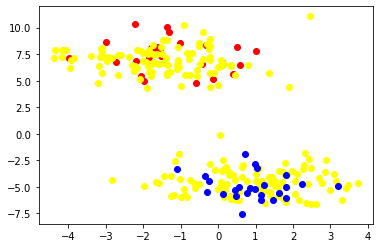

In [39]:
#lets take a step back and see our graph again.
#graph creation         
plt.scatter(class10,class11,color= 'red')
plt.scatter(class_unsampled0,class_unsampled1,color="yellow")
plt.scatter(class00,class01,color="blue")

plt.show()


## Initial Configuration of the Gaussian Mixture (plotting graph)

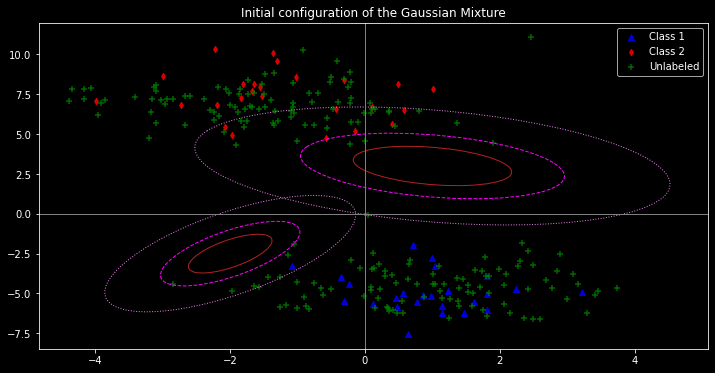

In [40]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
with plt.style.context('dark_background'):    
    fig, ax_nstd = plt.subplots(figsize=(12, 6))
    ax_nstd.axvline(c='grey', lw=1)
    ax_nstd.axhline(c='grey', lw=1)



    ax_nstd.scatter(mu[0], mu[1], c='violet',s=3)
    ax_nstd.set_title('Initial configuration of the Gaussian Mixture')

    confidence_ellipse(np.array(class00),np.array(class01) , ax_nstd, n_std=0.75,
       edgecolor='firebrick',angle = a1 , cov = c1 , mean_x = m1[0], mean_y = m1[1])

    confidence_ellipse(np.array(class00),np.array(class01) , ax_nstd, n_std=1.25,
     edgecolor='fuchsia', linestyle='--',angle = a1, cov = c1 , mean_x = m1[0], mean_y = m1[1])

    confidence_ellipse(np.array(class00),np.array(class01) , ax_nstd, n_std=2.25,
         edgecolor='violet', linestyle=':',angle = a1,  cov = c1 , mean_x = m1[0], mean_y = m1[1])




    confidence_ellipse(np.array(class10),np.array(class11) , ax_nstd, n_std=0.75,
         edgecolor='firebrick', cov = c2 ,angle = - a2, mean_x = m2[0], mean_y = m2[1])

    confidence_ellipse(np.array(class10),np.array(class11) , ax_nstd, n_std=1.25,
         edgecolor='fuchsia', linestyle='--',angle = - a2 ,cov = c2 , mean_x = m2[0], mean_y = m2[1])

    confidence_ellipse(np.array(class10),np.array(class11) , ax_nstd, n_std=2.25,
         edgecolor='violet', linestyle=':',angle = -a2, cov = c2 , mean_x = m2[0], mean_y = m2[1])
    
    ax_nstd.scatter(class00,class01,c ="blue",marker = "^",label = "Class 1",alpha = 0.8)
    ax_nstd.scatter(class10,class11,color= 'red',marker = "d",s=20,label = "Class 2",alpha = 0.8)
    ax_nstd.scatter(class_unsampled0,class_unsampled1,color="green",marker = "+",alpha = 0.8,label= "Unlabeled")
    
    ax_nstd.legend()
    

plt.show()

The two Gaussians are represented by the concentric ellipses that don't capture the actual structure of the dataset, we can now execute a training procedure. 


## Updating parameters 

Let's start by defining the temporary placeholdersfor the parameters computed at the previous iteration and a function to compute the sum of the norms of all differences between current and previous values:

In [41]:
from scipy.stats import multivariate_normal
threshold = 1e-4
def total_norm():
    global m1, m1_old, m2, m2_old, c1, c1_old, c2, c2_old, q1,q1_old
    global q2, q2_old
    sum1 = (np.linalg.norm(m1- m1_old)+
            np.linalg.norm(m2 - m2_old)  +
            np.linalg.norm(c1 - c1_old)  +
            np.linalg.norm(c2 - c2_old)  +
            np.linalg.norm(q1 - q1_old) +  
            np.linalg.norm(q2 - q2_old)) +0
    return  sum1

we can now define actual training procedure that will be iterated until the parameters become stable (that is, the sum of the norms **total_norm()** becomes smaller than the **threshold**):

In [45]:
m1_old  = np.zeros ((2,))
c1_old = np.zeros((2,2))
q1_old = 0 
m2_old = np.zeros((2,))
c2_old = np.zeros((2,2))
q2_old = 0 
while total_norm() > threshold:
    m1_old = m1.copy()
    c1_old = c1.copy()
    q1_old = q1
    m2_old = m2.copy()
    c2_old = c2.copy()
    q2_old = q2
    Pij = np.zeros((nb_samples,2))
    # E step
    for i in range(nb_samples):
        if Y[i] == -1:
            p1 = multivariate_normal.pdf(X[i],m1,c1, allow_singular = True)*q1
        
            p2 = multivariate_normal.pdf(X[i], m2,c2, allow_singular =True)*q2
        
            Pij[i] = [p1,p2]/(p1+p2)
        else: 
            Pij[i,:]  = [1.0,0.0] if Y[i] == 0 else [0.0,1.0]
    # M step
    n = np.sum(Pij,axis = 0)
    m = np.sum(np.dot(Pij.T,X),axis = 0)
    m1 = np.dot(Pij[:,0],X) / n[0]
    m2 = np.dot(Pij[:,1], X)/ n[1]
    q1 = n[0] / float(nb_samples)
    q2 = n[1] / float(nb_samples)
    c1 = np.zeros((2,2))
    c2 = np.zeros((2,2))
    for t in range(nb_samples):
        c1 += Pij[t,0]* np.outer(X[t]- m1,X[t] - m1)
        c2 += Pij[t,1] * np.outer(X[t] - m2, X[t]- m2)
    c1 /= n[0]
    c2 /=n[1]
print("cov 1: ")
print(c1)
print("")
print("cov 2: ")
print(c2)
print("----------------------------------------------------------------")
print("mean 1: ", m1)
print("")
print("mean 2: ", m2)
print("----------------------------------------------------------------")      
print("weight 1: ", q1)
print("")
print("weight 2: ", q2)
print("----------------------------------------------------------------")      
      

cov 1: 
[[ 1.7072436  -0.05665691]
 [-0.05665691  1.50982613]]

cov 2: 
[[ 1.80545932 -0.103192  ]
 [-0.103192    1.63271418]]
----------------------------------------------------------------
mean 1:  [ 0.92146656 -4.60693225]

mean 2:  [-1.44783054  6.97440478]
----------------------------------------------------------------
weight 1:  0.49999941278970517

weight 2:  0.5000005872102949
----------------------------------------------------------------


The first thing at the beginning of each cycle is to initialize the Pij matrix
that will be used to store the p(Yi|Xi hat; theta;w) values. Then, for each sample, we
can compute p(Yi|Xj;theta;w) considering whether it's labeled or not. The
Gaussian probability is computed using the SciPy function
multivariate_normal.pdf() . When the whole Pij matrix has been
populated, we can update the parameters (means and covariance matrix) of
both Gaussians and the relative weights. The algorithm is very fast: after
about five iterations, we get the stable state represented in the following
plot:

## Final Configuration of the Gaussian Mixture (plotting graph)

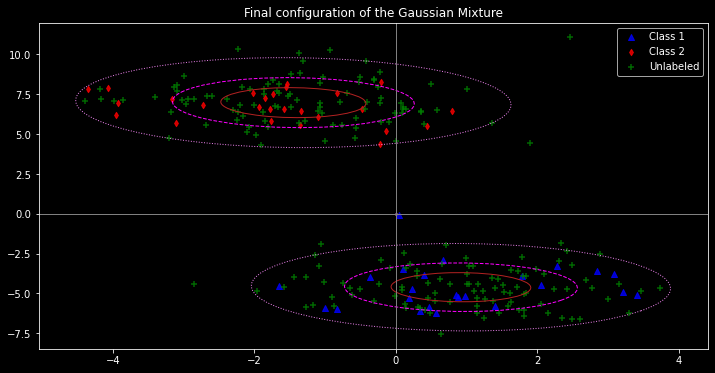

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
with plt.style.context('dark_background'):    
    fig, ax_nstd = plt.subplots(figsize=(12, 6))
    ax_nstd.axvline(c='grey', lw=1)
    ax_nstd.axhline(c='grey', lw=1)



    ax_nstd.scatter(mu[0], mu[1], c='violet',s=3)
    ax_nstd.set_title('Final configuration of the Gaussian Mixture')

    confidence_ellipse(np.array(class00),np.array(class01) , ax_nstd, n_std=0.75,
       edgecolor='firebrick',angle = a1 , cov = c1 , mean_x = m1[0], mean_y = m1[1])

    confidence_ellipse(np.array(class00),np.array(class01) , ax_nstd, n_std=1.25,
     edgecolor='fuchsia', linestyle='--',angle = a1, cov = c1 , mean_x = m1[0], mean_y = m1[1])

    confidence_ellipse(np.array(class00),np.array(class01) , ax_nstd, n_std=2.25,
         edgecolor='violet', linestyle=':',angle = a1,  cov = c1 , mean_x = m1[0], mean_y = m1[1])




    confidence_ellipse(np.array(class10),np.array(class11) , ax_nstd, n_std=0.75,
         edgecolor='firebrick', cov = c2 ,angle = - a2, mean_x = m2[0], mean_y = m2[1])

    confidence_ellipse(np.array(class10),np.array(class11) , ax_nstd, n_std=1.25,
         edgecolor='fuchsia', linestyle='--',angle = - a2 ,cov = c2 , mean_x = m2[0], mean_y = m2[1])

    confidence_ellipse(np.array(class10),np.array(class11) , ax_nstd, n_std=2.25,
         edgecolor='violet', linestyle=':',angle = -a2, cov = c2 , mean_x = m2[0], mean_y = m2[1])
    
    ax_nstd.scatter(class00,class01,c ="blue",marker = "^",label = "Class 1",alpha = 0.8)
    ax_nstd.scatter(class10,class11,color= 'red',marker = "d",s=20,label = "Class 2",alpha = 0.8)
    ax_nstd.scatter(class_unsampled0,class_unsampled1,color="green",marker = "+",alpha = 0.8,label= "Unlabeled")
    
    ax_nstd.legend()
    

plt.show()

the two Gaussianas have perfectly mapped space by setting their parameters so as to cover the hogh-density regions. We can check for some unlabeled points as follows:

In [47]:
print(np.round(X[Y==-1][0:5],3))

[[ 0.398 -3.857]
 [-1.866  7.496]
 [ 2.059 -5.662]
 [-0.752 -4.314]
 [ 0.145 -5.932]]


In [49]:
## It's easy to locate them in the previous plot. 
##The corresponding classes can be obtained through the last Pij matrix:
print(np.round(Pij[Y==-1][0:5],3))

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


This immediately verifies that they have been correctly labeled, and
assigned to the right cluster.

# END 
### -----------------------------------------------